In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools', 'sampling_utils')
sys.path.append(api_path)

In [83]:
import numpy as np
import random
import sklearn

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F


from sir_ais_sampling import (run_experiments_gaussians,
                              run_experiments_2_gaussians,
                              sir_correlated_dynamics,
                              sir_independent_dynamics)

from ebm_sampling import (citerais_mala_dynamics,
                          citerais_ula_dynamics, 
                          i_ais_z_dynamics,
                          i_ais_v_dynamics,
                          i_ais_b_dynamics)

from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal)

from torch.distributions import (MultivariateNormal, 
                                 Normal, 
                                 Independent, 
                                 Uniform)

from metrics import Evolution
from general_utils import DotDict, send_file_to_remote

In [84]:
from ebm_sampling import *

In [104]:
loc_target = 4.0
loc_proposal = 0.0

var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 100
strategy_mean = 'chain'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
batch_size = 250
n_steps = 100

In [105]:
dim = 100

target = init_independent_normal(scale_target, dim, 
                                       device, loc_target)
proposal = init_independent_normal(scale_proposal, dim, 
                                    device, loc_proposal)

In [106]:
N = 2

T = 100
betas = list(np.linspace(1., 0., T)**.5)
rhos = np.linspace(0.71, 0.7, T) #[0.9]*T #np.linspace(1, .7, T)


grad_step = 0.1
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N, 
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale, 
                 'betas': betas,
                 'rho': 1.0,
                 'rhos': rhos}

In [128]:
start = proposal.sample([batch_size, len(betas)])


In [132]:
history, acceptence, traj_hist = citerais_ula_dynamics(start, 
                                                target.log_prob,
                                                proposal,
                                                method_params['n_steps'], 
                                                method_params['grad_step'], 
                                                method_params['eps_scale'],
                                                method_params['N'], 
                                                method_params['betas'],
                                                method_params['rhos']
                                                )

100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


In [133]:
trs = torch.stack(traj_hist, 0)

In [134]:
trs.shape

torch.Size([101, 5, 100, 100])

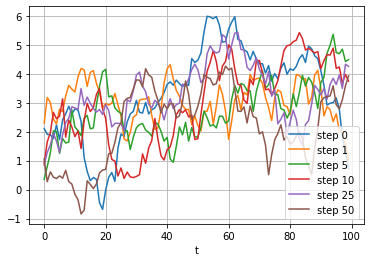

In [135]:
from matplotlib import pyplot as plt

id = 1
dim_id = 5
steps = [0, 1, 5, 10, 25, 50]
for step in steps:
    plt.plot(np.arange(trs.shape[2]), trs[step, id, :, dim_id], label=f'step {step}')

plt.legend()
plt.xlabel('t')
#plt.ylabel(f'{dim_id} coordinate')
plt.grid()
#plt.savefig(f'../../diff_rho{rhos[0]:.1f}.png')

In [136]:
# plt.plot(np.arange(78)+1, acceptence[120].mean(1))
# plt.savefig('../../accept_rate.png')

In [137]:
#acceptence[-1].mean(0)

In [138]:
start_res = torch.stack(history, 0)
print('fraction of acceptions of initial traj', (start_res[1:] != start_res[:-1]).float().min(-1)[0][0].mean().item())

fraction of acceptions of initial traj 0.5720000267028809


In [139]:
last_history = history[-num_points_in_chain:]
result = torch.stack(last_history, 0)#[..., -1, :]

In [140]:
print('fraction of acceptions', (result[1:] != result[:-1]).float().min(-1)[0].mean().item())
# print((result[1:] != result[:-1]).float()[..., 0][0].mean(0)[0].item())

fraction of acceptions 0.27539393305778503


In [141]:
result_np = result.cpu().numpy()

In [142]:
# over chain
result_var = np.var(result_np, axis = 0, ddof=1).mean(axis = 0)#.mean()
result_mean = np.mean(result_np, axis = 0).mean(axis = 0)#.mean()

# # over batch
# result_var = np.var(result_np, axis = 1, ddof=1).mean(axis = 0).mean()
# result_mean = np.mean(result_np, axis = 1).mean(axis = 0).mean()

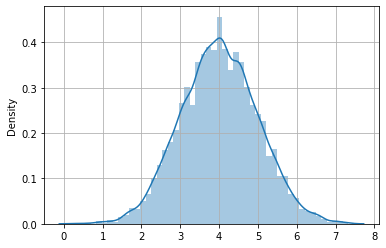

In [143]:
import seaborn as sns

dim_id = 15
sns.distplot(result_np[..., dim_id])
plt.grid()

#plt.savefig(f'../../hist_rho{rhos[0]:.1f}_dim{dim_id}.png')

In [144]:
result_mean, result_var, result_mean.mean(), result_var.mean()

(array([3.982006 , 3.9983597, 4.019899 , 3.9709167, 3.9763346, 3.9783328,
        3.9695423, 4.0194383, 3.9831917, 4.026318 , 4.013516 , 3.9813123,
        3.9818945, 3.9940932, 3.9982166, 4.0083857, 4.000633 , 3.9553392,
        4.016383 , 4.0301313, 4.0003185, 4.0051904, 4.0297327, 4.025935 ,
        3.9936035, 3.9808488, 4.009419 , 3.957586 , 4.002905 , 4.0006104,
        3.9778328, 4.010834 , 3.988063 , 3.960836 , 4.021541 , 3.9914496,
        4.003393 , 3.9885972, 4.041334 , 4.0091877, 3.9588728, 3.9889886,
        4.0000477, 4.009167 , 3.9955437, 3.9952097, 3.9666152, 3.9604917,
        4.0613127, 4.02339  , 3.9533572, 4.021493 , 4.00482  , 4.012811 ,
        4.016052 , 3.9953709, 4.008778 , 4.003207 , 4.003209 , 3.9820874,
        3.9595702, 3.9979672, 3.9975402, 3.9756978, 4.021533 , 3.9841452,
        3.9884062, 4.0100536, 3.9524794, 4.00319  , 4.0332713, 3.9522994,
        4.019149 , 3.987309 , 3.9867244, 3.9951837, 3.9992948, 4.0110393,
        4.0145946, 4.016666 , 3.990146

In [147]:
dim_arr = [100]

N = 2

T = 100
betas = np.linspace(1., 0., T)**.5
rhos = [0.]*T

grad_step = 0.1
eps_scale = (2*grad_step)**0.5

n_steps = 100

method_params = {'n_steps': n_steps, 
                 'N': N, 
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale, 
                 'betas': betas,
                 'rhos': rhos,
                 'rho': 1.0}
random_seed = 46
method = 'citerais_ula' 
mode_init = 'proposal'
print_results = True
strategy_mean = 'chain'

results_citerais_ula = run_experiments_gaussians(dim_arr,  
                                          scale_proposal, 
                                          scale_target, 
                                          loc_target,
                                          num_points_in_chain, 
                                          strategy_mean,
                                          device,
                                          batch_size,
                                          method_params,
                                          random_seed = random_seed,
                                          loc_proposal = loc_proposal,
                                          mode_init = mode_init,
                                          method = method,
                                          print_results = print_results) 

  0%|          | 0/100 [00:00<?, ?it/s]------------------
mode = proposal
dim = 100
100%|██████████| 100/100 [00:22<00:00,  4.53it/s]
mean estimation of acceptence rate = 1.0
mean estimation of variance = 0.9835978150367737
mean estimation of mean = 3.996108055114746
mean estimation of ess = 0.26056565656565656
------


In [149]:
loc_1_target = 3
loc_2_target = -3

target_args = DotDict()
target_args.device = device
target_args.num_gauss = 2

coef_gaussian = 1./target_args.num_gauss
target_args.p_gaussians = [torch.tensor(coef_gaussian)]*target_args.num_gauss
locs = [loc_1_target*torch.ones(dim, dtype = torch.float64).to(device),
    loc_2_target*torch.ones(dim, dtype = torch.float64).to(device)]
locs_numpy = torch.stack(locs, axis = 0).cpu().numpy()
target_args.locs = locs
target_args.covs = [(scale_target**2)*torch.eye(dim, 
                                                dtype = torch.float64).to(device)]*target_args.num_gauss
target_args.dim = dim
target = Gaussian_mixture(target_args)
proposal = init_independent_normal(scale_proposal, dim, device, loc_proposal)

In [150]:
N = 2

T = 100
betas = list(np.linspace(1., 0., T)**.5)
rhos = [0.] * T #np.linspace(1, .0, T)#**.5

#betas = list(np.linspace(1., 0.85, 50)) + list(np.linspace(0.85, 0., 30))

grad_step = 0.1
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N, 
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale, 
                 'betas': betas,
                 'rho': 1.0,
                 'rhos': rhos}

In [151]:
batch_size = 50

In [152]:
start = proposal.sample([batch_size, len(betas)])

In [153]:
history, acceptence, traj_hist = citerais_ula_dynamics(start, 
                                                target.log_prob,
                                                proposal,
                                                method_params['n_steps'], 
                                                method_params['grad_step'], 
                                                method_params['eps_scale'],
                                                method_params['N'], 
                                                method_params['betas'],
                                                method_params['rhos']
                                                )

100%|██████████| 100/100 [00:24<00:00,  4.02it/s]


In [154]:
history[-1].shape

torch.Size([50, 100])

In [159]:
last_history = history[-num_points_in_chain:]
result = torch.stack(last_history, 0)
print('fraction of acceptions', (result[1:] != result[:-1]).float().min(-1)[0].mean().item())

result_np = result.cpu().numpy()
# over chain
result_var = np.var(result_np, axis = 0, ddof=1).mean(axis = 0)#.mean()
result_mean = np.mean(result_np, axis = 0).mean(axis = 0)#.mean()


fraction of acceptions 0.27030304074287415


In [160]:
result_np.shape

(100, 50, 100)

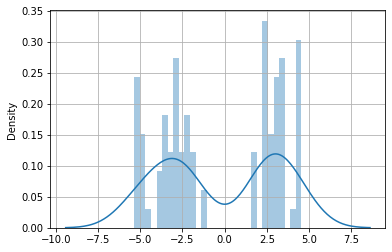

In [161]:
import seaborn as sns

dim_id = 4
chain_id = 45
sns.distplot(result_np[:, chain_id, dim_id], bins=30)
plt.grid()
#plt.savefig('../../hist.png')

In [162]:
from scipy.stats import chi2

test_dist = (chi2.ppf(.95, dim) * (scale_target**2))**.5

(np.linalg.norm(result_np - np.array([-3.]*dim)[None, None, :], axis=-1) < test_dist).sum()

2357

In [163]:
result_np.shape

(100, 50, 100)

In [164]:
trs = torch.stack(traj_hist, 0)

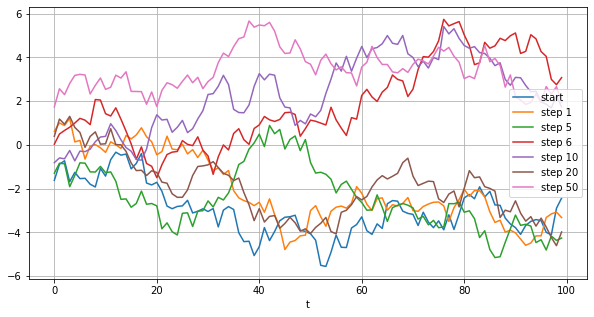

In [165]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
id = 1
dim_id = 6
plt.plot(np.arange(trs.shape[2]), trs[0, id, :, dim_id], label='start')
plt.plot(np.arange(trs.shape[2]), trs[1, id, :, dim_id], label='step 1')
plt.plot(np.arange(trs.shape[2]), trs[5, id, :, dim_id], label='step 5')
plt.plot(np.arange(trs.shape[2]), trs[6, id, :, dim_id], label='step 6')
plt.plot(np.arange(trs.shape[2]), trs[10, id, :, dim_id], label='step 10')
plt.plot(np.arange(trs.shape[2]), trs[20, id, :, dim_id], label='step 20')
plt.plot(np.arange(trs.shape[2]), trs[50, id, :, dim_id], label='step 50')
plt.legend()
plt.xlabel('t')
#plt.ylabel(f'{dim_id} coordinate')
plt.grid()
#plt.savefig('../../diff.png')

In [166]:
trs.shape

torch.Size([101, 5, 100, 100])

In [167]:
dim_arr = [100]

batch_size = 100

mode_init = 'proposal'
method = 'citerais_ula'
print_results = True
strategy_mean = 'chain'

random_seed = 506

N = 2

T = 70 #100
betas = list(np.linspace(1., 0., T)**.25)
rhos = [.0]*T #np.linspace(.4, .0, T)#**.5#[::-1]#**3#**.5
#rhos[-1] = 1


grad_step = 0.1
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N, 
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale, 
                 'betas': betas,
                 'rho': 1.0,
                 'rhos': rhos}

result = run_experiments_2_gaussians(dim_arr,
                                              scale_proposal,
                                              scale_target,
                                              loc_1_target,
                                              loc_2_target,
                                              num_points_in_chain,
                                              strategy_mean,
                                              device,
                                              batch_size,
                                              method_params,
                                              random_seed=random_seed,
                                              loc_proposal=loc_proposal,
                                              mode_init=mode_init,
                                              method=method,
                                              print_results=print_results)

  0%|          | 0/100 [00:00<?, ?it/s]------------------
mode = proposal
dim = 100
100%|██████████| 100/100 [00:20<00:00,  4.92it/s]
mean estimation of acceptence rate = 1.0
mean estimation of target variance = 0.8340828955203017
mean estimation of 1 mode mean  = 2.9941394329071045
mean estimation of 2 mode mean  = -2.998189926147461
mean estimation of JSD  = 0.005991067488211854
mean estimation of HQR  = 0.9828000092506408
mean estimation of ESS = 0.2768686868686869
------


In [169]:
method_params['rhos'] = [0.7]*T

In [170]:
result = run_experiments_2_gaussians(dim_arr,
                                              scale_proposal,
                                              scale_target,
                                              loc_1_target,
                                              loc_2_target,
                                              num_points_in_chain,
                                              strategy_mean,
                                              device,
                                              batch_size,
                                              method_params,
                                              random_seed=random_seed,
                                              loc_proposal=loc_proposal,
                                              mode_init=mode_init,
                                              method=method,
                                              print_results=print_results)

  0%|          | 0/100 [00:00<?, ?it/s]------------------
mode = proposal
dim = 100
100%|██████████| 100/100 [00:20<00:00,  4.97it/s]
mean estimation of acceptence rate = 1.0
mean estimation of target variance = 0.766730602427649
mean estimation of 1 mode mean  = 2.986027240753174
mean estimation of 2 mode mean  = -2.9890706539154053
mean estimation of JSD  = 0.019418458612635164
mean estimation of HQR  = 0.9878000062704086
mean estimation of ESS = 0.28202020202020206
------
